# 2D Transient Navier-Stokes Flow in an Open/Closed Channel

## Import Packages 

In [33]:
using Ferrite, SparseArrays, BlockArrays, LinearAlgebra, UnPack, LinearSolve, WriteVTK
using OrdinaryDiffEq
using FerriteGmsh
using FerriteGmsh: Gmsh
using Plots # added for simple plotting functionality 

## Section 1: Introduction 

<b>Problem to Solve</b> 

<b>Goals</b>

<b>Questions</b>

<b>Remarks</b>
1. function ferrite_limiter!(): (from Ferrite developers) in order to obtain correct higher order convergence for time-dependent Dirichlet conditions, one needs to ensure that all the internal buffers are also correctly set at all times. The limiter helps guarantees this (as the time integrators do also other stuff than just calling your right-hand side). See e.g. [rosenbrock_perform_step.jl](https://github.com/SciML/OrdinaryDiffEq.jl/blob/7a4a5fb6d95f78e973b3d7bb41861058d5b00881/lib/OrdinaryDiffEqRosenbrock/src/rosenbrock_perform_step.jl#L1386-L1388);

More later.

### Unknown Stiffness Problems

When the stiffness of the problem is unknown, it is recommended you use a stiffness detection and auto-switching algorithm. These methods are multi-paradigm and allow for efficient solution of both stiff and non-stiff problems. The cost for auto-switching is very minimal, but the choices are restrained. They are a good go-to method when applicable.

For default tolerances, AutoTsit5(Rosenbrock23()) is a good choice. For lower tolerances, using AutoVern7 or AutoVern9 with Rodas4, KenCarp4, or Rodas5P can all be good choices depending on the problem. For very large systems (>1000 ODEs?), consider using lsoda.

## Section 2: Home-Brewed Post-Processing

In [34]:
function mypostprocess(u, dh)
 
    area = [] 
    velx = [] 
    vely = []
    velm = [] 
    pres = []

    for (cell_num, cell) in enumerate(CellIterator(dh))

        dof_range_u = dof_range(dh,:v)
        dof_range_p = dof_range(dh,:p)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        ploc = u[celldofs(dh,cell_num)[dof_range_p]]
        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell)

        cellarea = 0. 
        cellvelocity = [0.,0.]
        cellpressure = 0 
    
        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            velocity = function_value(cellvalues_v, q_point, uloc)
            cellarea += dΩ 
            cellvelocity += velocity*dΩ
        end

        for q_point in 1:getnquadpoints(cellvalues_p)
            dΩ = getdetJdV(cellvalues_p, q_point)
            pressure = function_value(cellvalues_p, q_point, ploc)
            cellpressure += pressure*dΩ
        end

        append!(area, cellarea)
        append!(velx, cellvelocity[1]/cellarea) 
        append!(vely, cellvelocity[2]/cellarea)
        append!(velm, norm(cellvelocity)/cellarea)
        append!(pres, cellpressure/cellarea)
    
    end  

    velx2d = reshape(velx, nels)
    vely2d = reshape(vely, nels)
    velm2d = reshape(velm, nels)
    pres2d = reshape(pres, nels)
    
    return area, velx2d, vely2d, velm2d, pres2d  
end 

mypostprocess (generic function with 1 method)

## Section 3: 2D Mesh Generation 

In [24]:
#..geomettry parameters 
L = 1. 
R = 0.1
nels  = (40, 20) # number of elements in each spatial direction
left  = Vec((0., 0.))  # start point for geometry 
right = Vec((L, R,))   # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);
#..mesh in x-direction and y-direction - intended for debugging 
xgrid = Vector(range(0, L, step=L/nels[1]))
ygrid = Vector(range(0, R, step=R/nels[2]))
#..lower left grid node - intended for pressure constraint. 
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

Grid{2, Quadrilateral, Float64} with 800 Quadrilateral cells and 861 nodes

## Section 4: Assembly of Stiffness and Mass Matrix

In [25]:
function assemble_mass_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, M::SparseMatrixCSC, dh::DofHandler)
    # Allocate a buffer for the local matrix and some helpers, together with the assembler.
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Mₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # It follows the assembly loop as explained in the basic tutorials.
    mass_assembler = start_assemble(M)
    for cell in CellIterator(dh)
        fill!(Mₑ, 0)
        Ferrite.reinit!(cellvalues_v, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            # Remember that we assemble a vector mass term, hence the dot product.
            # There is only one time derivative on the left hand side, so only one mass block is non-zero.
            for i in 1:n_basefuncs_v
                φᵢ = shape_value(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    φⱼ = shape_value(cellvalues_v, q_point, j)
                    Mₑ[BlockIndex((v▄, v▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
                end
            end
        end
        assemble!(mass_assembler, celldofs(cell), Mₑ)
    end

    return M
end;

function assemble_stokes_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, ν, K::SparseMatrixCSC, dh::DofHandler)
    # Again, some buffers and helpers
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Kₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # Assembly loop
    stiffness_assembler = start_assemble(K)
    for cell in CellIterator(dh)
        # Don't forget to initialize everything
        fill!(Kₑ, 0)

        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)

            for i in 1:n_basefuncs_v
                ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    ∇φⱼ = shape_gradient(cellvalues_v, q_point, j)
                    Kₑ[BlockIndex((v▄, v▄), (i, j))] -= ν * ∇φᵢ ⊡ ∇φⱼ * dΩ
                end
            end

            for j in 1:n_basefuncs_p
                ψ = shape_value(cellvalues_p, q_point, j)
                for i in 1:n_basefuncs_v
                    divφ = shape_divergence(cellvalues_v, q_point, i)
                    Kₑ[BlockIndex((v▄, p▄), (i, j))] += (divφ * ψ) * dΩ
                    Kₑ[BlockIndex((p▄, v▄), (j, i))] += (ψ * divφ) * dΩ
                end
            end
        end

        # Assemble `Kₑ` into the Stokes matrix `K`.
        assemble!(stiffness_assembler, celldofs(cell), Kₑ)
    end
    return K
end;

## Section 5: Spatial Discretization 
<b>Remark</b>
1. The inlet velocity is ramped until reach $1.5 \, \text{m/s}$; 

In [55]:
dim = 2 
degree = 2
ν = 1e0 # 1.0 / 1000.0; #dynamic viscosity

ip_v = Lagrange{RefQuadrilateral, 2}()^dim
qr = QuadratureRule{RefQuadrilateral}(4)
cellvalues_v = CellValues(qr, ip_v);

ip_p = Lagrange{RefQuadrilateral, 1}()
cellvalues_p = CellValues(qr, ip_p);

dh = DofHandler(grid)
add!(dh, :v, ip_v)
add!(dh, :p, ip_p)
close!(dh);

ch = ConstraintHandler(dh);

# Ramp the inlet velocity 
vmax = 1. 
vin(t) = min(t * vmax, vmax) #inflow velocity
parabolic_inflow_profile(x,t) = Vec((vin(t)*4*x[2]*(R - x[2])/R^2, 0.0))

# Case-(1/3)
if (true)
    # Inlet: Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
    inlet = getfacetset(dh.grid, "left")
    dbc1 = Dirichlet(:v, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
    add!(ch, dbc1)

    # Walls: Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
    wall = union(
        getfacetset(grid, "top"),
        # getfacetset(grid, "right"),
        getfacetset(grid, "bottom"), 
    )
    dbc2 = Dirichlet(:v, wall, (x, t) -> [0, 0])
    add!(ch, dbc2)
    
    # Boundary conditions part (3/3): apply pressure constraint
    dbc3 = Dirichlet(:p, getfacetset(grid, "right"), (x, t) -> 0)
    add!(ch, dbc3)
end 

∂Ω_free = getfacetset(grid, "right");

close!(ch)
update!(ch, 0.0);

## Section 6: Time-Integration Using DifferentialEquations.jl 

In [56]:
T = 6.0
Δt₀ = 0.001
Δt_save = 0.1

M = allocate_matrix(dh);
M = assemble_mass_matrix(cellvalues_v, cellvalues_p, M, dh);

K = allocate_matrix(dh);
K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, ν, K, dh);

u₀ = zeros(ndofs(dh))
apply!(u₀, ch);

jac_sparsity = sparse(K);

apply!(M, ch)

struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    dh::DofHandler
    cellvalues_v::CellValues
    u::Vector
end
p = RHSparams(K, ch, dh, cellvalues_v, copy(u₀))

function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

function navierstokes_rhs_element!(dvₑ, vₑ, cellvalues_v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    for q_point in 1:getnquadpoints(cellvalues_v)
        dΩ = getdetJdV(cellvalues_v, q_point)
        ∇v = function_gradient(cellvalues_v, q_point, vₑ)
        v = function_value(cellvalues_v, q_point, vₑ)
        for j in 1:n_basefuncs
            φⱼ = shape_value(cellvalues_v, q_point, j)

            dvₑ[j] -= v ⋅ ∇v' ⋅ φⱼ * dΩ
        end
    end
    return
end

function navierstokes!(du, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    # nonlinear contribution
    v_range = dof_range(dh, :v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    vₑ = zeros(n_basefuncs)
    duₑ = zeros(n_basefuncs)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues_v, cell)
        v_celldofs = @view celldofs(cell)[v_range]
        vₑ .= @views u[v_celldofs]
        fill!(duₑ, 0.0)
        navierstokes_rhs_element!(duₑ, vₑ, cellvalues_v)
        assemble!(du, v_celldofs, duₑ)
    end
    return
end;

function navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    for q_point in 1:getnquadpoints(cellvalues_v)
        dΩ = getdetJdV(cellvalues_v, q_point)
        ∇v = function_gradient(cellvalues_v, q_point, vₑ)
        v = function_value(cellvalues_v, q_point, vₑ)
        for j in 1:n_basefuncs
            φⱼ = shape_value(cellvalues_v, q_point, j)

            for i in 1:n_basefuncs
                φᵢ = shape_value(cellvalues_v, q_point, i)
                ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
                Jₑ[j, i] -= (φᵢ ⋅ ∇v' + v ⋅ ∇φᵢ') ⋅ φⱼ * dΩ
            end
        end
    end
    return
end

function navierstokes_jac!(J, u_uc, p, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    assembler = start_assemble(J; fillzero = false)

    # Assemble variation of the nonlinear term
    n_basefuncs = getnbasefunctions(cellvalues_v)
    Jₑ = zeros(n_basefuncs, n_basefuncs)
    vₑ = zeros(n_basefuncs)
    v_range = dof_range(dh, :v)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues_v, cell)
        v_celldofs = @view celldofs(cell)[v_range]

        vₑ .= @views u[v_celldofs]
        fill!(Jₑ, 0.0)
        navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
        assemble!(assembler, v_celldofs, Jₑ)
    end

    return apply!(J, ch)
end;

rhs = ODEFunction(navierstokes!, mass_matrix=M; jac=navierstokes_jac!, jac_prototype=jac_sparsity)
problem = ODEProblem(rhs, u₀, (0.0,T), p);

struct FreeDofErrorNorm
    ch::ConstraintHandler
end
(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

timestepper = Rodas5P(autodiff=false, step_limiter! = ferrite_limiter!);

integrator = init(
    problem, timestepper; initializealg=NoInit(), dt=Δt₀,
    adaptive=true, abstol=1e-4, reltol=1e-5,
    progress=true, progress_steps=1,
    verbose=true, internalnorm=FreeDofErrorNorm(ch), d_discontinuities=[1.0]
);

pvd = paraview_collection("vortex-street")
for (step, (u,t)) in enumerate(intervals(integrator))
    VTKGridFile("vortex-street-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end
vtk_save(pvd);

## Section 7: Solve Again, This Time Using the Solve Function `

In [57]:
sol = solve(
    problem, timestepper; initializealg=NoInit(), dt=Δt₀,
    adaptive=true, abstol=1e-4, reltol=1e-5,
    progress=true, progress_steps=1,
    verbose=true, internalnorm=FreeDofErrorNorm(ch), d_discontinuities=[1.0]
);

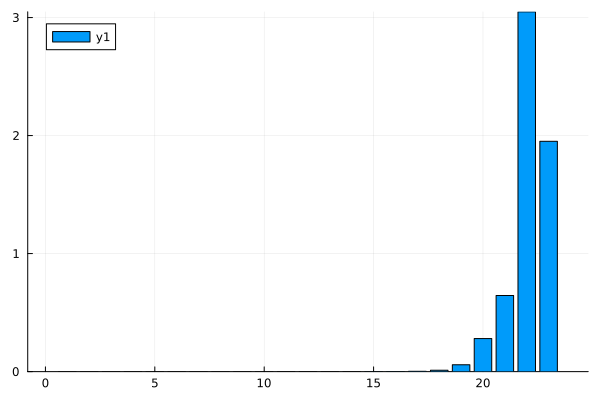

In [58]:
dt = sol.t[2:end] - sol.t[1:end-1]; 
bar(dt)

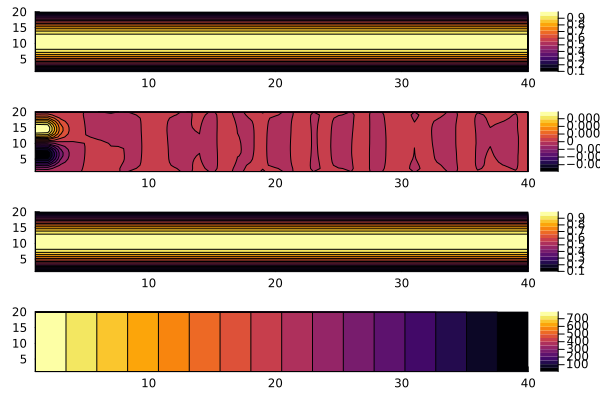

In [59]:
# post-process solution 
area, velx2d, vely2d, velm2d, pres2d = mypostprocess(sol.u[end], dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(velm2d', fill=true)
p4 = contour(pres2d', fill=true)
plot(p1,p2,p3,p4,layout=(4,1))

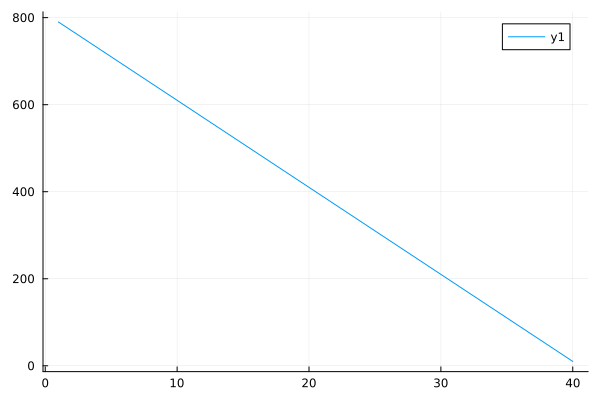

In [60]:
plot(pres2d[:,10])